### 数据集说明，数据集是维基百科访问流量，ds表示时间，y表示流量

使用Prophet预测manning未来365天的页面流量，从2007年12月10日开始

In [21]:
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
from fbprophet.plot import add_changepoints_to_plot

In [22]:
get_ipython().run_line_magic('matplotlib', 'inline')

In [23]:
# 读入数据集
df = pd.read_csv('../examples/example_wp_log_peyton_manning.csv')

In [24]:
# 拟合模型
m1 = Prophet()  
m1.growth

'linear'

In [25]:
m1.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [26]:
print(m1.changepoints)
print(len(m1.changepoints))

93     2008-03-17
186    2008-06-20
279    2008-10-11
372    2009-01-14
465    2009-04-17
558    2009-07-19
650    2009-10-26
743    2010-01-31
836    2010-05-06
929    2010-08-14
1022   2010-11-15
1115   2011-02-16
1208   2011-05-20
1301   2011-08-21
1394   2011-11-24
1487   2012-02-27
1580   2012-05-31
1673   2012-09-01
1765   2012-12-02
1858   2013-03-05
1951   2013-06-06
2044   2013-09-08
2137   2013-12-10
2230   2014-03-14
2323   2014-06-15
Name: ds, dtype: datetime64[ns]
25


In [27]:
# 构建待预测日期数据框，periods = 365 代表除历史数据的日期外再往后推 365 天
future = m1.make_future_dataframe(periods=365)
future.tail()

,ds
3265,2017-01-15
3266,2017-01-16
3267,2017-01-17
3268,2017-01-18
3269,2017-01-19


In [28]:
# 预测数据集
forecast = m1.predict(future)
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [29]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3265,2017-01-15,8.213297,7.519591,8.922006
3266,2017-01-16,8.538360,7.890708,9.294296
3267,2017-01-17,8.325759,7.679427,9.048473
3268,2017-01-18,8.158421,7.351764,8.918330
3269,2017-01-19,8.170360,7.478946,8.883969


In [30]:
forecast.shape

(3270, 19)

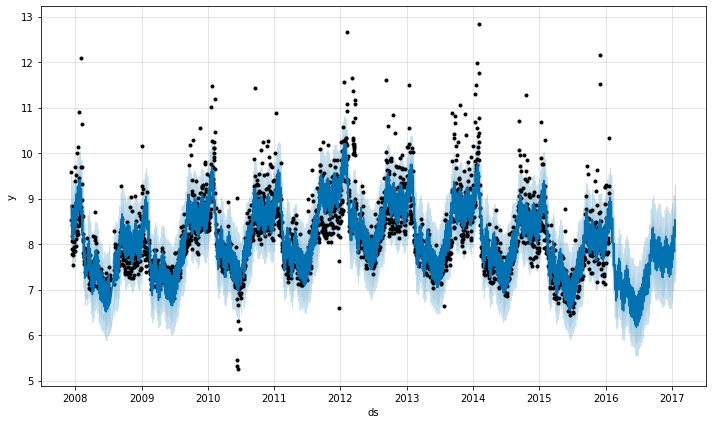

In [31]:
# 展示预测结果
fig = m1.plot(forecast)
f1=plt.show()

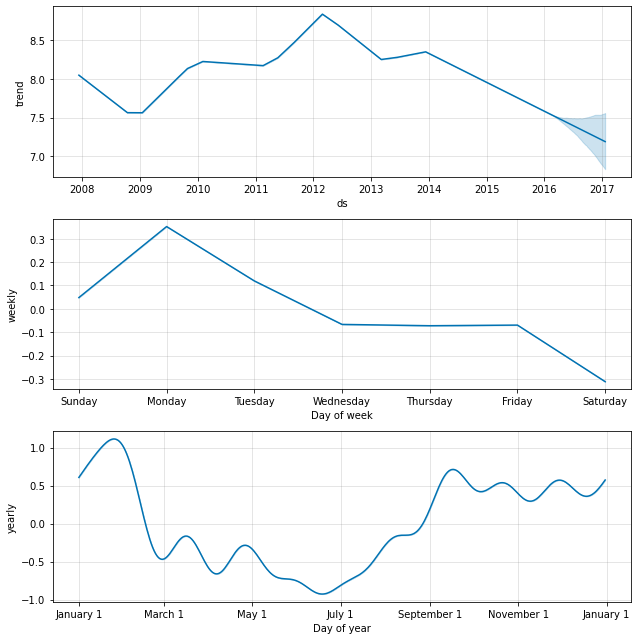

In [32]:
# 预测的成分分析绘图，展示预测中的趋势、周效应和年度效应
f2=m1.plot_components(forecast)

### 使用逻辑模型

In [33]:
# https://facebook.github.io/prophet/docs/saturating_forecasts.html
# 默认 Prophet使用线性模型。但市场规模是有最大饱和值的，这叫做cap(carrying capacity).
# 使用逻辑趋势(logistic growth trend)模型需要指定cap的值，每条数据都必须有cap值，可以每行数据的cap值相同，也可以增长或降低
m2 = Prophet(growth='logistic', seasonality_mode='multiplicative')
df['cap'] = 8.5
m2.growth

'logistic'

In [34]:
m2.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [35]:
# 预测未来 5 年的数据
future = m2.make_future_dataframe(periods=1826)

In [36]:
# 将未来的承载能力设定的和历史数据一样，即8.5
future['cap'] = 8.5

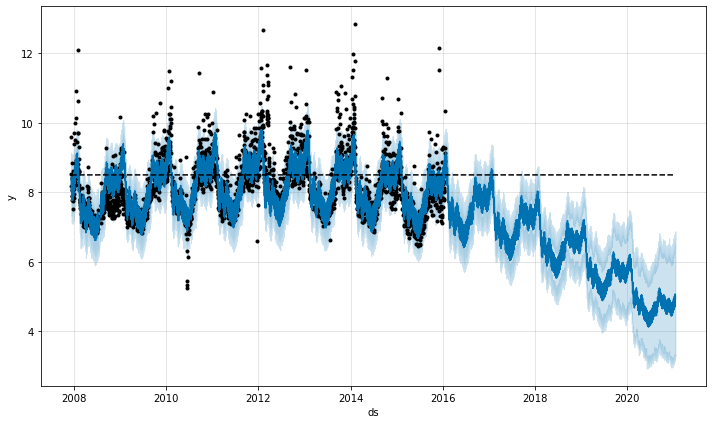

In [37]:
fcst = m2.predict(future)
f3 = m2.plot(fcst)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


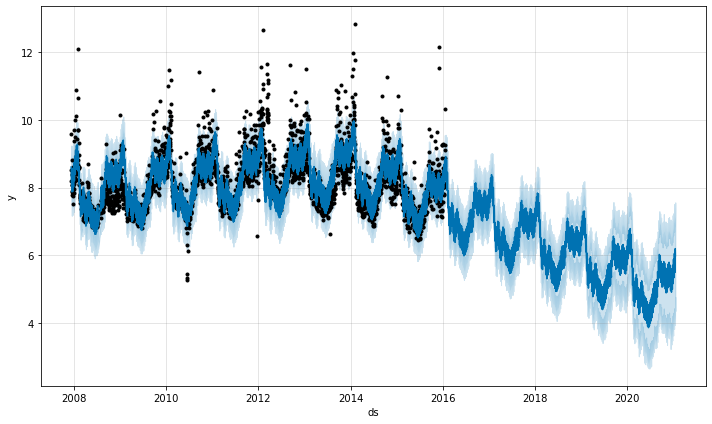

In [38]:
# 指定突变点的位置
m4 = Prophet(changepoints=['2014-01-01'])
m4.fit(df)
future = m4.make_future_dataframe(periods=1826)
forecast = m4.predict(future)
fig4 = m4.plot(forecast)

### 对节假日建模

将节日看成是一个正态分布，把活动期间当做波峰，lower_window 以及upper_window 的窗口作为扩散

In [39]:
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
holidays = pd.concat((playoffs, superbowls))

In [41]:
m5 = Prophet(holidays=holidays)
m5.fit(df)
future = m5.make_future_dataframe(periods=365)
forecast = m5.predict(future)
print(forecast.tail())

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
3265 2017-01-15  7.202094    7.346096    8.708924     6.845904     7.547663   
3266 2017-01-16  7.201111    7.697566    9.047852     6.842506     7.547989   
3267 2017-01-17  7.200127    7.499762    8.845023     6.839269     7.548248   
3268 2017-01-18  7.199143    7.350057    8.736473     6.835533     7.548489   
3269 2017-01-19  7.198160    7.367281    8.794960     6.832766     7.549503   

      additive_terms  additive_terms_lower  additive_terms_upper  holidays  \
3265        0.832073              0.832073              0.832073       0.0   
3266        1.167655              1.167655              1.167655       0.0   
3267        0.993707              0.993707              0.993707       0.0   
3268        0.830128              0.830128              0.830128       0.0   
3269        0.846423              0.846423              0.846423       0.0   

      ...    weekly  weekly_lower  weekly_upper    yearl

In [42]:
# 通过 forecast 数据框，展示节假日效应
print(forecast[(forecast['playoff'] + forecast['superbowl']).abs() > 0][['ds', 'playoff', 'superbowl']][-10:])

             ds   playoff  superbowl
2190 2014-02-02  1.223246   1.202105
2191 2014-02-03  1.901703   1.455167
2532 2015-01-11  1.223246   0.000000
2533 2015-01-12  1.901703   0.000000
2901 2016-01-17  1.223246   0.000000
2902 2016-01-18  1.901703   0.000000
2908 2016-01-24  1.223246   0.000000
2909 2016-01-25  1.901703   0.000000
2922 2016-02-07  1.223246   1.202105
2923 2016-02-08  1.901703   1.455167


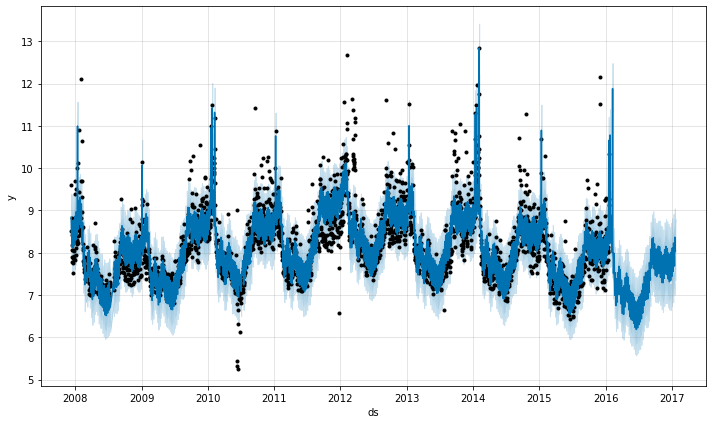

In [43]:
fig5 = m5.plot(forecast)

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'holidays', 'holidays_lower', 'holidays_upper', 'playoff',
       'playoff_lower', 'playoff_upper', 'superbowl', 'superbowl_lower',
       'superbowl_upper', 'weekly', 'weekly_lower', 'weekly_upper', 'yearly',
       'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')


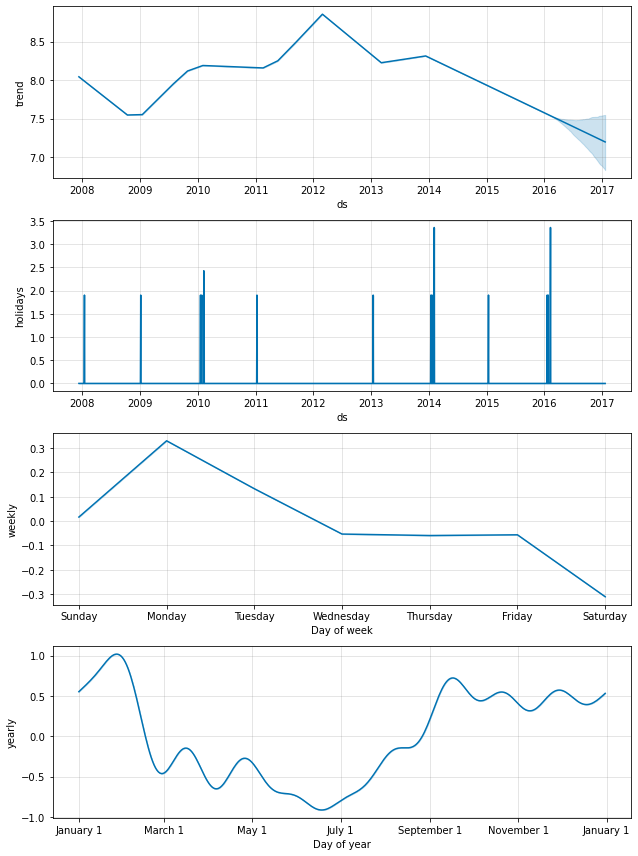

In [45]:
# 预测的成分分析绘图，展示预测中的趋势、周效应和年度效应,holidays项
m5.plot_components(forecast)
print(forecast.columns)